<a href="https://colab.research.google.com/github/j0ngle/ASL_Classifier/blob/main/ASL_Classifier_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Task: Create a neural network to classify ASL alphabet signs

# Preprocessing Data

The following code was run locally to preprocess the images it completes the following tasks:

1. Converts each image to a numpy array

2. Grayscales the images

3. Scales images from 200x200 to 50x50

4. Saves all information to csv files as strings

In [ ]:
# import numpy as np
# import pandas as pd
# import cv2
# import os
# import ast
# import sys

# def process_image(img_path):
#     #Convert to numpy array
#     img = cv2.imread(img_path)

#     #Grayscale image
#     img = np.dot(img[...,:3], [.2989, .5870, .1140])

#     #Resize image
#     img = cv2.resize(img, dsize=(50, 50), interpolation=cv2.INTER_NEAREST)

#     return img


# ######################################
# #TRAIN


# save_path = ""

# train_path = "asl_alphabet_train/"

# total = 87000
# iter = 0

# train_images = [None] * total
# train_labels = [None] * total



# for folder in os.listdir(train_path):

#   folder_path = train_path + folder + "/"
#   print("Processing folder: ", folder)

#   for filename in os.listdir(train_path + folder):
#     if filename.endswith("jpg"):
#         img = None

#         img = process_image(folder_path + filename)

#         #Reshape image for easy conversion later
#         train_images[iter] = np.reshape(img, (-1, 50*50))
#         train_labels[iter] = folder

#         iter += 1


# train_whole = pd.DataFrame()
# train_whole['images'] = train_images
# train_whole['labels'] = train_labels

# np.set_printoptions(threshold=sys.maxsize)

# train_whole.to_csv('ASL_train.csv')

# print("Done!\n")

# ######################################
# #TEST
# print("Started processing test images")

# test_path = "asl_alphabet_test/"

# test_images = []
# test_labels = []

# for filename in os.listdir(test_path):
#   if filename.endswith("jpg"):
#     print("Processing: ", filename)
#     img = process_image(test_path + filename)
#     test_images.append(np.reshape(img, (-1, 50*50)))
#     #test_images.append(img)

#     s = filename.split('_')
#     test_labels.append(s[0])


# test_whole = pd.DataFrame()
# test_whole['images'] = test_images
# test_whole['labels'] = test_labels

# test_whole.to_csv('ASL_test.csv')

Getting the and processing the CSVs

In [ ]:
import os
import pandas as pd

HOUSING_PATH = os.path.join("datasets", "asl")
os.makedirs(HOUSING_PATH, exist_ok=True)

def get_csv_path(filename, path):
  csv_path = os.path.join(path, filename)
  return pd.read_csv(csv_path)

In [ ]:
train_whole = get_csv_path('ASL_train.csv', '/content/drive/MyDrive/Summer 2021 AI Research Stuff/Colab Files/Resources/')
test_whole = get_csv_path('ASL_test.csv', '/content/drive/MyDrive/Summer 2021 AI Research Stuff/Colab Files/Resources/')

train_whole.head()

,Unnamed: 0,images,labels
0,0,[[ 76.6108 74.1272 75.1379 74.3937 74.2134...,A
1,1,[[ 78.8448 72.0349 75.1379 74.9314 74.0886...,A
2,2,[[ 80.3177 74.0455 75.4799 73.4477 76.4043...,A
3,3,[[ 80.0296 73.6156 75.2519 76.5291 72.9316...,A
4,4,[[ 77.6816 73.138 72.779 72.0133 72.9038...,A


The image data is saved to the csv as strings of 1D arrays of length 2500. Because of how Pandas' to_csv works, there are new line characters every 8 entries. Below are the steps to convert these string back to numpy arrays

1. Get rid of end brackets by getting the substring of each image from index 2 to index len(< str >) - 2

2. Use numpy's .fromstring function on \n separators to convert the string to an array

3. Reshape the numpy array with .reshape to get the original 50x50 image

After the list is filled, I am going to ditch the dataframe and convert all of the lists to numpy arrays. I had previously replaced the index in the dataframe with updated values, but that wasn't playing nice with model.fit() later. Sending them straight to numpy arrays with .asarray() should address this problem

Another Note: I forgot that I need my labels to be integers and I'm not running the preprocessing step again, so I'm just going to encode them manually here

In [ ]:
import numpy as np

length = len(train_whole['images'])
img_array_train = [None] * length
label_array_train = [None] * length

for i in range(0, length):
  #Grab image
  img = train_whole['images'][i]

  #Get substring (omitting brackets)
  img = img[2:len(img) - 2]

  #Convert to array, reshape, and add to new list
  img_array_train[i] = np.fromstring(img, sep='\n').reshape(50, 50)

  #Handling labels
  label = train_whole['labels'][i]
  if len(label) == 1:
    label_array_train[i] = ord(label) - ord('A')
  else:
    if label == 'nothing':
      label_array_train[i] = 26
    elif label == 'space':
      label_array_train[i] = 27
    elif label == 'del':
      label_array_train[i] = 28

length = len(test_whole['images'])
img_array_test = [None] * length
label_array_test = [None] * length

for i in range(0, length):
  img = test_whole['images'][i]

  img = img[2:len(img) - 2]

  img_array_test[i] = np.fromstring(img, sep='\n').reshape(50, 50)

  label = test_whole['labels'][i]
  if len(label) == 1:
    label_array_test[i] = ord(label) - ord('A')
  else:
    if label == 'nothing':
      label_array_test[i] = 26
    elif label == 'space':
      label_array_test[i] = 27
    elif label == 'del':
      label_array_test[i] = 28

In [ ]:
class_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L',
       'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U',
       'V', 'W', 'X', 'Y', 'Z', 'nothing', 'space', 'del']

In [ ]:
from sklearn.utils import shuffle

#x represents data
#y represents labels
x_train_whole = shuffle(np.asarray(img_array_train), random_state=42)
y_train_whole = shuffle(np.asarray(label_array_train), random_state=42)

#Testing images provided by Kaggle contributor.
#Only 1 image per sign
#I don't think I'll need to shuffle this, but the code is here just in case
# x_test_small = shuffle(np.asarray(img_array_test), random_state=42)
# y_test_small = shuffle(np.asarray(label_array_test), random_state=42)

#Grabbing roughly 20% (~17000 instances) of the training set to use
#as a larger scale testing set
#Dividing by 255 to reduce the complexity of the inputs, putting them in a range
#0-1
x_test, x_train = x_train_whole[:17000] / 255.0, x_train_whole[17000:] / 255.0
y_test, y_train = y_train_whole[:17000], y_train_whole[17000:]

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(70000, 50, 50)
(70000,)
(17000, 50, 50)
(17000,)


Just confirming that the data is formatted correctly

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

def plot_sign(img, label):
  plt.imshow(img, cmap='binary')
  plt.axis('off')
  plt.show()
  print(class_names[label])

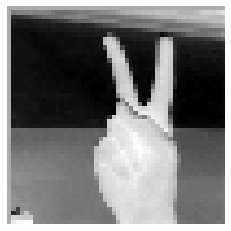

K


In [ ]:
instance = 0
plot_sign(x_train[instance], y_train[instance])

All of the data appears to be formatted and labeled correctly. The Kaggle contibutor incluced a test set, but there is only 1 image for each sign (totalling 29 images including del, nothing, and space).

I'm going to make a new test set containing about 20% of all of the training data and then a validation set containing a fraction of what remains. This way there is adequate material to train, validate, and test on

# Creating the Model

I ran the sequential model as follows 1st and achieved and accuracy of .9526 on the training data and .9445 on the validation data! 

~~~
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[50, 50]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(29, activation="softmax"))
~~~


Based on the graph, it doesn't look like it had converged quite yet, so I could stand to run it again for a few more epochs.

Before I do that, I read that adding a Batch Normalization layer between each hidden layer can improve results and is almost expected in NN models. So I'm going to run the following model and see how it performs. It also says that for 2 hidden layers it probably won't help much, but it's good to have

~~~
model = keras.models.Sequential([
                  keras.layers.Flatten(input_shape=[50, 50]),
                  keras.layers.BatchNormalization(),
                  keras.layers.Dense(300, activation="relu"),
                  keras.layers.BatchNormalization(),   
                  keras.layers.Dense(100, activation="relu"),
                  keras.layers.BatchNormalization(),     
                  keras.layers.Dense(29, activation="softmax") 
])
~~~

Turns out Batch Normalization helped a lot here! I finished with a training accuracy of .9698 and a validation accuracy of .9814. And it seems like the model converged within 30 epochs this time, so there is no need to run it again

In [ ]:
import tensorflow as tf
from tensorflow import keras

model = keras.models.Sequential([
                  keras.layers.Flatten(input_shape=[50, 50]),
                  keras.layers.BatchNormalization(),
                  keras.layers.Dense(300, activation="relu"),
                  keras.layers.BatchNormalization(),   
                  keras.layers.Dense(100, activation="relu"),
                  keras.layers.BatchNormalization(),     
                  keras.layers.Dense(29, activation="softmax") 
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 2500)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2500)              10000     
_________________________________________________________________
dense (Dense)                (None, 300)               750300    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_2 (Dense)              (None, 29)                2

We are using sparse categorical crossentropy because the labels are integer values representing indoces in the class list. 

Categorical crossentropy requires one hot encoding of our labels to work properly.

Sparse is a little misleading in that it appears to imply that we do not have labels for all of our values, but rather it is just basically saying they aren't one-hot encoded

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [ ]:
history = model.fit(x_train, y_train, 
                    epochs=30,
                    validation_split=0.08)

Epoch 1/30
2013/2013 [==============================] - 42s 20ms/step - loss: 1.6978 - accuracy: 0.5036 - val_loss: 1.0025 - val_accuracy: 0.7002
Epoch 2/30
2013/2013 [==============================] - 31s 15ms/step - loss: 0.9008 - accuracy: 0.7274 - val_loss: 0.6520 - val_accuracy: 0.8055
Epoch 3/30
2013/2013 [==============================] - 30s 15ms/step - loss: 0.6553 - accuracy: 0.7988 - val_loss: 0.4913 - val_accuracy: 0.8454
Epoch 4/30
2013/2013 [==============================] - 30s 15ms/step - loss: 0.5230 - accuracy: 0.8375 - val_loss: 0.3861 - val_accuracy: 0.8802
Epoch 5/30
2013/2013 [==============================] - 32s 16ms/step - loss: 0.4321 - accuracy: 0.8641 - val_loss: 0.3534 - val_accuracy: 0.8911
Epoch 6/30
2013/2013 [==============================] - 38s 19ms/step - loss: 0.3767 - accuracy: 0.8800 - val_loss: 0.2815 - val_accuracy: 0.9107
Epoch 7/30
2013/2013 [==============================] - 32s 16ms/step - loss: 0.3263 - accuracy: 0.8963 - val_loss: 0.2824 -

That looks promising!

Checking the graph, it seems like the loss and accuracy have converged, so we can go on to testing

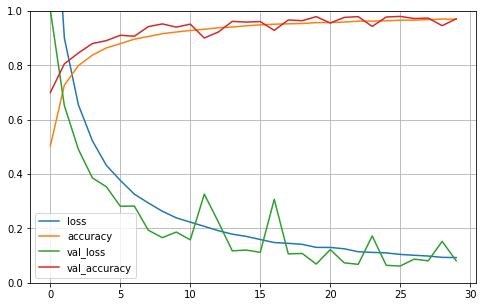

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

# Testing

I think for this I will start by predicting the classes for all of my test data. Then I'll iterate over the results against the labels manually and keep track of how many the NN got right. 

In [ ]:
#I would use model.predict_classes here, but it deprecated and Keras suggests I
#do this instead
y_pred = np.argmax(model.predict(x_test), axis=-1)
y_pred

array([17,  8, 10, ..., 15, 16, 22])

In [ ]:
total = 0
correct = 0
for i in range(0, len(y_test)):
  total += 1

  if (y_pred[i] == y_test[i]):
    correct += 1

In [ ]:
correct / total

0.971